In [1]:
# Figure S5

In [2]:
import re
import warnings

import cmaps 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from gcpy import single_panel 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 
import regionmask
import scipy.stats as stats
from scipy.stats import gmean, gstd
import seaborn as sns 
import xarray as xr 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [13]:
# Original simulations
def get_original_values(variable, sim, conversion_factor=1, resolution='c48'):
    
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim}.Emissions.april-august.nc4")
    da = ds[variable]*conversion_factor
    
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland


In [15]:
def get_sensitivity_values(variable, simulation, year, conversion_factor=1, resolution='c48'):
    
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{simulation}.{variable}.april-august.{year}.nc4")
    da = ds[variable]*conversion_factor
    
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    if resolution=='c90':
        da_monthly_noland = tools.mask_ocean_c90(da_monthly)
    elif resolution=='c48':
        da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland

In [5]:
def quantile_error(data):
    central = np.mean(data)
    lower = np.quantile(data, 0.025)
    upper = np.quantile(data, 0.975)
    return [central - lower, upper - central]  # Negative and positive errors

In [6]:
ar6_region = {
        "ENA": 5,
        "EAS": 58,
        "WCE": 17,
    }

In [7]:
def calculate_regional_mean_std(da, months, region, resolution='c48'):
    """
    Calculate the mean and standard deviation for a specific region and month.
    """
    if resolution == 'c48':
        cropped_da = tools.crop_regionmask_ar6_c48(da, region_num=ar6_region[region])
    elif resolution == 'c90':
        cropped_da = tools.crop_regionmask_ar6_c90(da, region_num=ar6_region[region])
    elif resolution == 'latlon':
        cropped_da = crop_regionmask_ar6(da, region_num=ar6_region[region])

    subset = cropped_da.sel(time=cropped_da.time.dt.month.isin(months))
    seasonal_mean = subset.resample(time='1Y').mean()

    if 'nf' in seasonal_mean.dims:
        regional_mean = seasonal_mean.mean(dim=['nf', 'Ydim', 'Xdim'])
    if 'lat' in seasonal_mean.dims:
        regional_mean = seasonal_mean.mean(dim=['lat', 'lon'])
    mean = regional_mean.mean().values
    std = quantile_error(regional_mean.values)
    return mean, std

In [8]:
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [9]:
def reshape_data(data):
    """
    Reshapes a list of pairs into a 2D array with separate lists for each index.

    Parameters:
    data (list of list): A list of pairs, where each pair is [x, y].

    Returns:
    list of list: A 2D array where the first row contains all first elements of the pairs
                  and the second row contains all second elements.
    """
    # Transpose the data using zip
    reshaped = [list(i) for i in zip(*data)]
    return reshaped

In [16]:
# Spatial Ozone Response Comparison: c48 vs c90
variable = "EmisISOP_Biogenic"

variable_string = "Biogenic isoprene emissions"
# 1000g/kg * (60.06/68.12) kgC/kgISOP * 86400 s/day * 365.25 days/year
conversion_factor = 1000 * (60.06/68.12)  * 86400 * (365.25)

ref = get_original_values(variable, "all_ref_c48", conversion_factor=conversion_factor, resolution='c48')
refshort = get_original_values(variable, "all_refshort_c48", conversion_factor=conversion_factor, resolution='c48')

simulation = "w10_ref_c48_noCO2effect"
year = 2000
ref_isop = get_sensitivity_values(variable, simulation, year=year, conversion_factor=conversion_factor, resolution='c48')

simulation = "w10_refshort_c48_noCO2effect"
year = 2080
refshort_isop = get_sensitivity_values(variable, simulation, year=year, conversion_factor=conversion_factor, resolution='c48')

In [17]:
# Part 2: Regional Mean Ozone Response Comparison: c48 vs c90
datasets = {
    "ref": {
        "data": ref,
        "resolution": 'c48'
        
    },
    "refshort": {
        "data": refshort,
        "resolution": 'c48'
    },
    "refisop": {
        "data": ref_isop,
        "resolution": 'c48'
        
    },
    "refshortisop": {
        "data": refshort_isop,
        "resolution": 'c48'
    }
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    ds_resolution = ds_info["resolution"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  # e.g. "ENA"
        results[ds_name][result_key] = calculate_regional_mean_std(
                ds_data, comparison_months, region, resolution=ds_resolution
            )

In [18]:
# Part 3: Regional Mean Ozone Response Comparison: cam vs m2
ref_mean = extract_means("ref")
refshort_mean = extract_means("refshort")

refisop_mean = extract_means("refisop")
refshortisop_mean = extract_means("refshortisop")

ref_std  = extract_stds("ref")
refshort_std  = extract_stds("refshort")

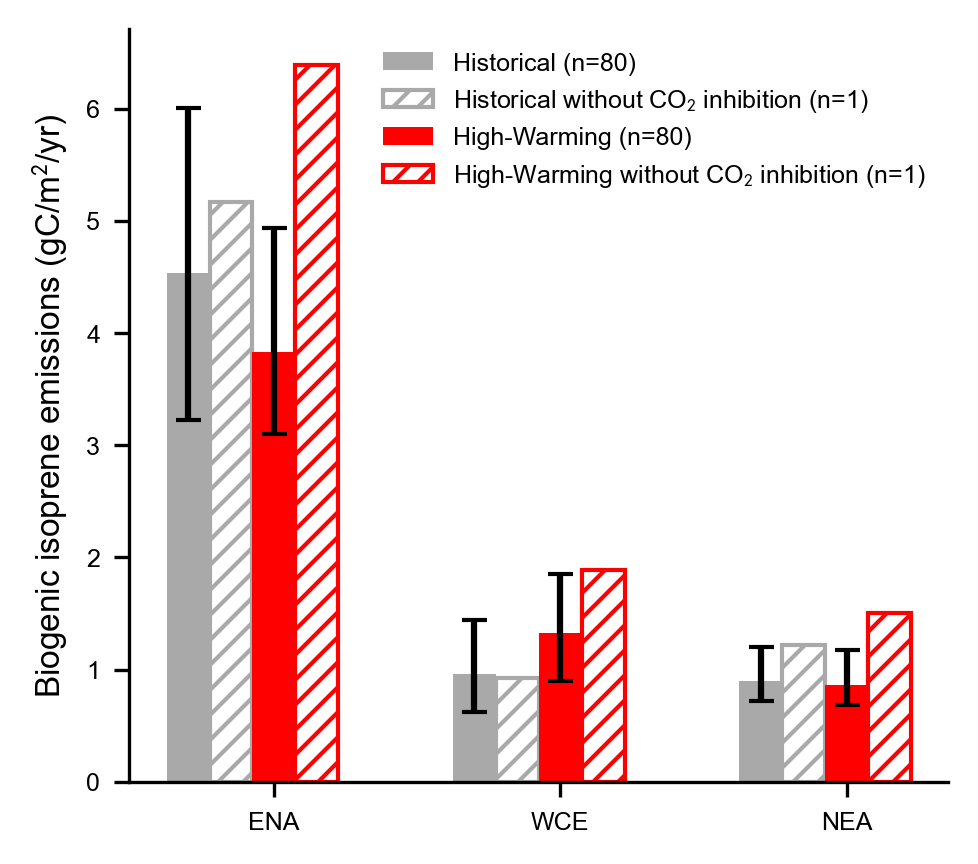

In [19]:
%matplotlib inline 

bar_width = 0.15
categories = ['ENA', 'WCE', 'NEA']
x = np.arange(len(categories))

tools.set_matplotlib_font("Arial")
mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 6,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6, 
    'legend.fontsize': 6,
    'figure.titlesize': 8
})


fig = plt.figure(figsize=(3.33, 2.85), dpi=300)
gs1 = GridSpec(1, 1, top=0.95, bottom=0.07, left=0.15, right=0.97, hspace=0.50, wspace=0.4)
axes = fig.add_subplot(gs1[0, 0])

axes.bar(x - 2*bar_width, ref_mean, bar_width, yerr=reshape_data(ref_std),      capsize=3, label="Historical (n=80)", color="darkgray", lw=0.5)
axes.bar(x - bar_width,   refisop_mean, bar_width, label="Historical without CO$_2$ inhibition (n=1)", color="white", hatch='////', edgecolor="darkgray")

axes.bar(x,   refshort_mean,    bar_width, yerr=reshape_data(refshort_std), capsize=3, label="High-Warming (n=80)", color="red")
axes.bar(x + bar_width, refshortisop_mean, bar_width, label="High-Warming without CO$_2$ inhibition (n=1)", color="white", hatch='////', edgecolor="red")

axes.set_ylabel(f"{variable_string} (gC/m$^2$/yr)", fontsize=8)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(fontsize=6, frameon=False)

plt.xticks(x, categories, fontsize=6)

#######################################
plt.savefig("FigS5_new.png")

In [20]:
# Calculate percentage increase in isoprene emissions with CO2 effect 
first = ref_mean
second = refshort_mean

# Calculate the percentage increase for each corresponding element using a tuple comprehension
percentage_increase = tuple(
    ((new - old) / old * 100) for old, new in zip(first, second)
)

absolute_increase = tuple(
    (new - old) for old, new in zip(first, second)
)


# Print the results
print("Percentage increases (in %):", percentage_increase)
print("Absolute increases (in K):", absolute_increase)

# Calculate percentage increase in isoprene emissions WITHOUT CO2 effect 
first = refisop_mean
second = refshortisop_mean

# Calculate the percentage increase for each corresponding element using a tuple comprehension
percentage_increase = tuple(
    ((new - old) / old * 100) for old, new in zip(first, second)
)

absolute_increase = tuple(
    (new - old) for old, new in zip(first, second)
)


# Print the results
print("Percentage increases (in %):", percentage_increase)
print("Absolute increases (in K):", absolute_increase)

Percentage increases (in %): (-15.68005234003067, 38.41656446456909, -4.110909625887871)
Absolute increases (in K): (-0.71168685, 0.36855102, -0.03703916)
Percentage increases (in %): (23.62266331911087, 104.32157516479492, 23.417191207408905)
Absolute increases (in K): (1.2205195, 0.9644382, 0.28561115)
